In [1]:
import pygmt
import numpy as np
import pandas as pd
import geopy.distance

In [2]:
#Some initialzation for pyGMT
# define the map (study) extents
min_lon = -82
max_lon = -66
min_lat = -5
max_lat = 14
# read in the topograpy for generating background map
grid = pygmt.datasets.load_earth_relief(region=[min_lon,max_lon,min_lat,max_lat],resolution='15s')

In [3]:
colombia_stations = 'Colombia-Noise.csv'
ecuador_stations = 'Ecuador-Noise.csv'
#sim_stations = 'Sim-25km-Noise.csv'
sim_stations = 'Sim-50km-Noise.csv'
#sim_stations = 'Sim-100km-Noise.csv'
earthquakes_file = 'Earthquakes.csv'
cities_file = 'Cities.csv'

In [16]:
# Read in station locations and noise for each station
dfE = pd.read_csv(ecuador_stations)
dfC = pd.read_csv(colombia_stations)
#dfS = pd.read_csv(sim_stations)
#frames = [dfC, dfE, dfS ]
frames = [dfC, dfE ]
df = pd.concat(frames)

In [17]:
cities = pd.read_csv(cities_file)
cities

,Latitude,Longitude,City
0,4.7110,-74.0721,Bogota
1,6.2476,-75.5658,Medellin
2,3.4516,-76.5320,Cali
3,11.0041,-74.8070,Barranquilla
4,10.3932,-75.4832,Cartagena


In [18]:
eqs = pd.read_csv(earthquakes_file)
eqs['Date'] = pd.to_datetime(eqs['Date'])
eqs

,Latitude,Longitude,Depth,Date,Mw
0,4.800,-77.180,19.1,1991-11-19,7.2
1,4.720,-77.570,16.0,2004-11-15,7.2
2,2.849,-74.798,55.0,2067-02-09,7.0
3,0.955,-79.369,25.0,2006-01-31,8.8
4,0.025,-79.955,25.0,2042-05-14,7.8
5,1.000,-79.400,60.0,2058-01-19,7.8
6,0.380,-79.950,20.0,2016-04-16,7.7
7,2.320,-78.810,19.7,1979-12-12,8.1


In [27]:
index=1
eq_loc = [eqs.iloc[index,0], eqs.iloc[index,1]]
cindex=0
city_loc = [cities.iloc[cindex,0], cities.iloc[cindex,1]]
#minimum number of stations for detection
min = 4
#Seimic velocity in km/sec
vel = 4
# Time required to process and issue warning
issue = 6

In [28]:
df['distance']   = df.apply(lambda row: geopy.distance.geodesic( eq_loc,(row.lat,row.lon)).km, axis=1)
df.sort_values(by='distance', inplace=True, ignore_index=True)

In [29]:
city_dist = geopy.distance.geodesic(eq_loc,city_loc).km 
dect_dist = df.loc[min-1,'distance']
warning_time_sec = (city_dist - dect_dist)/vel

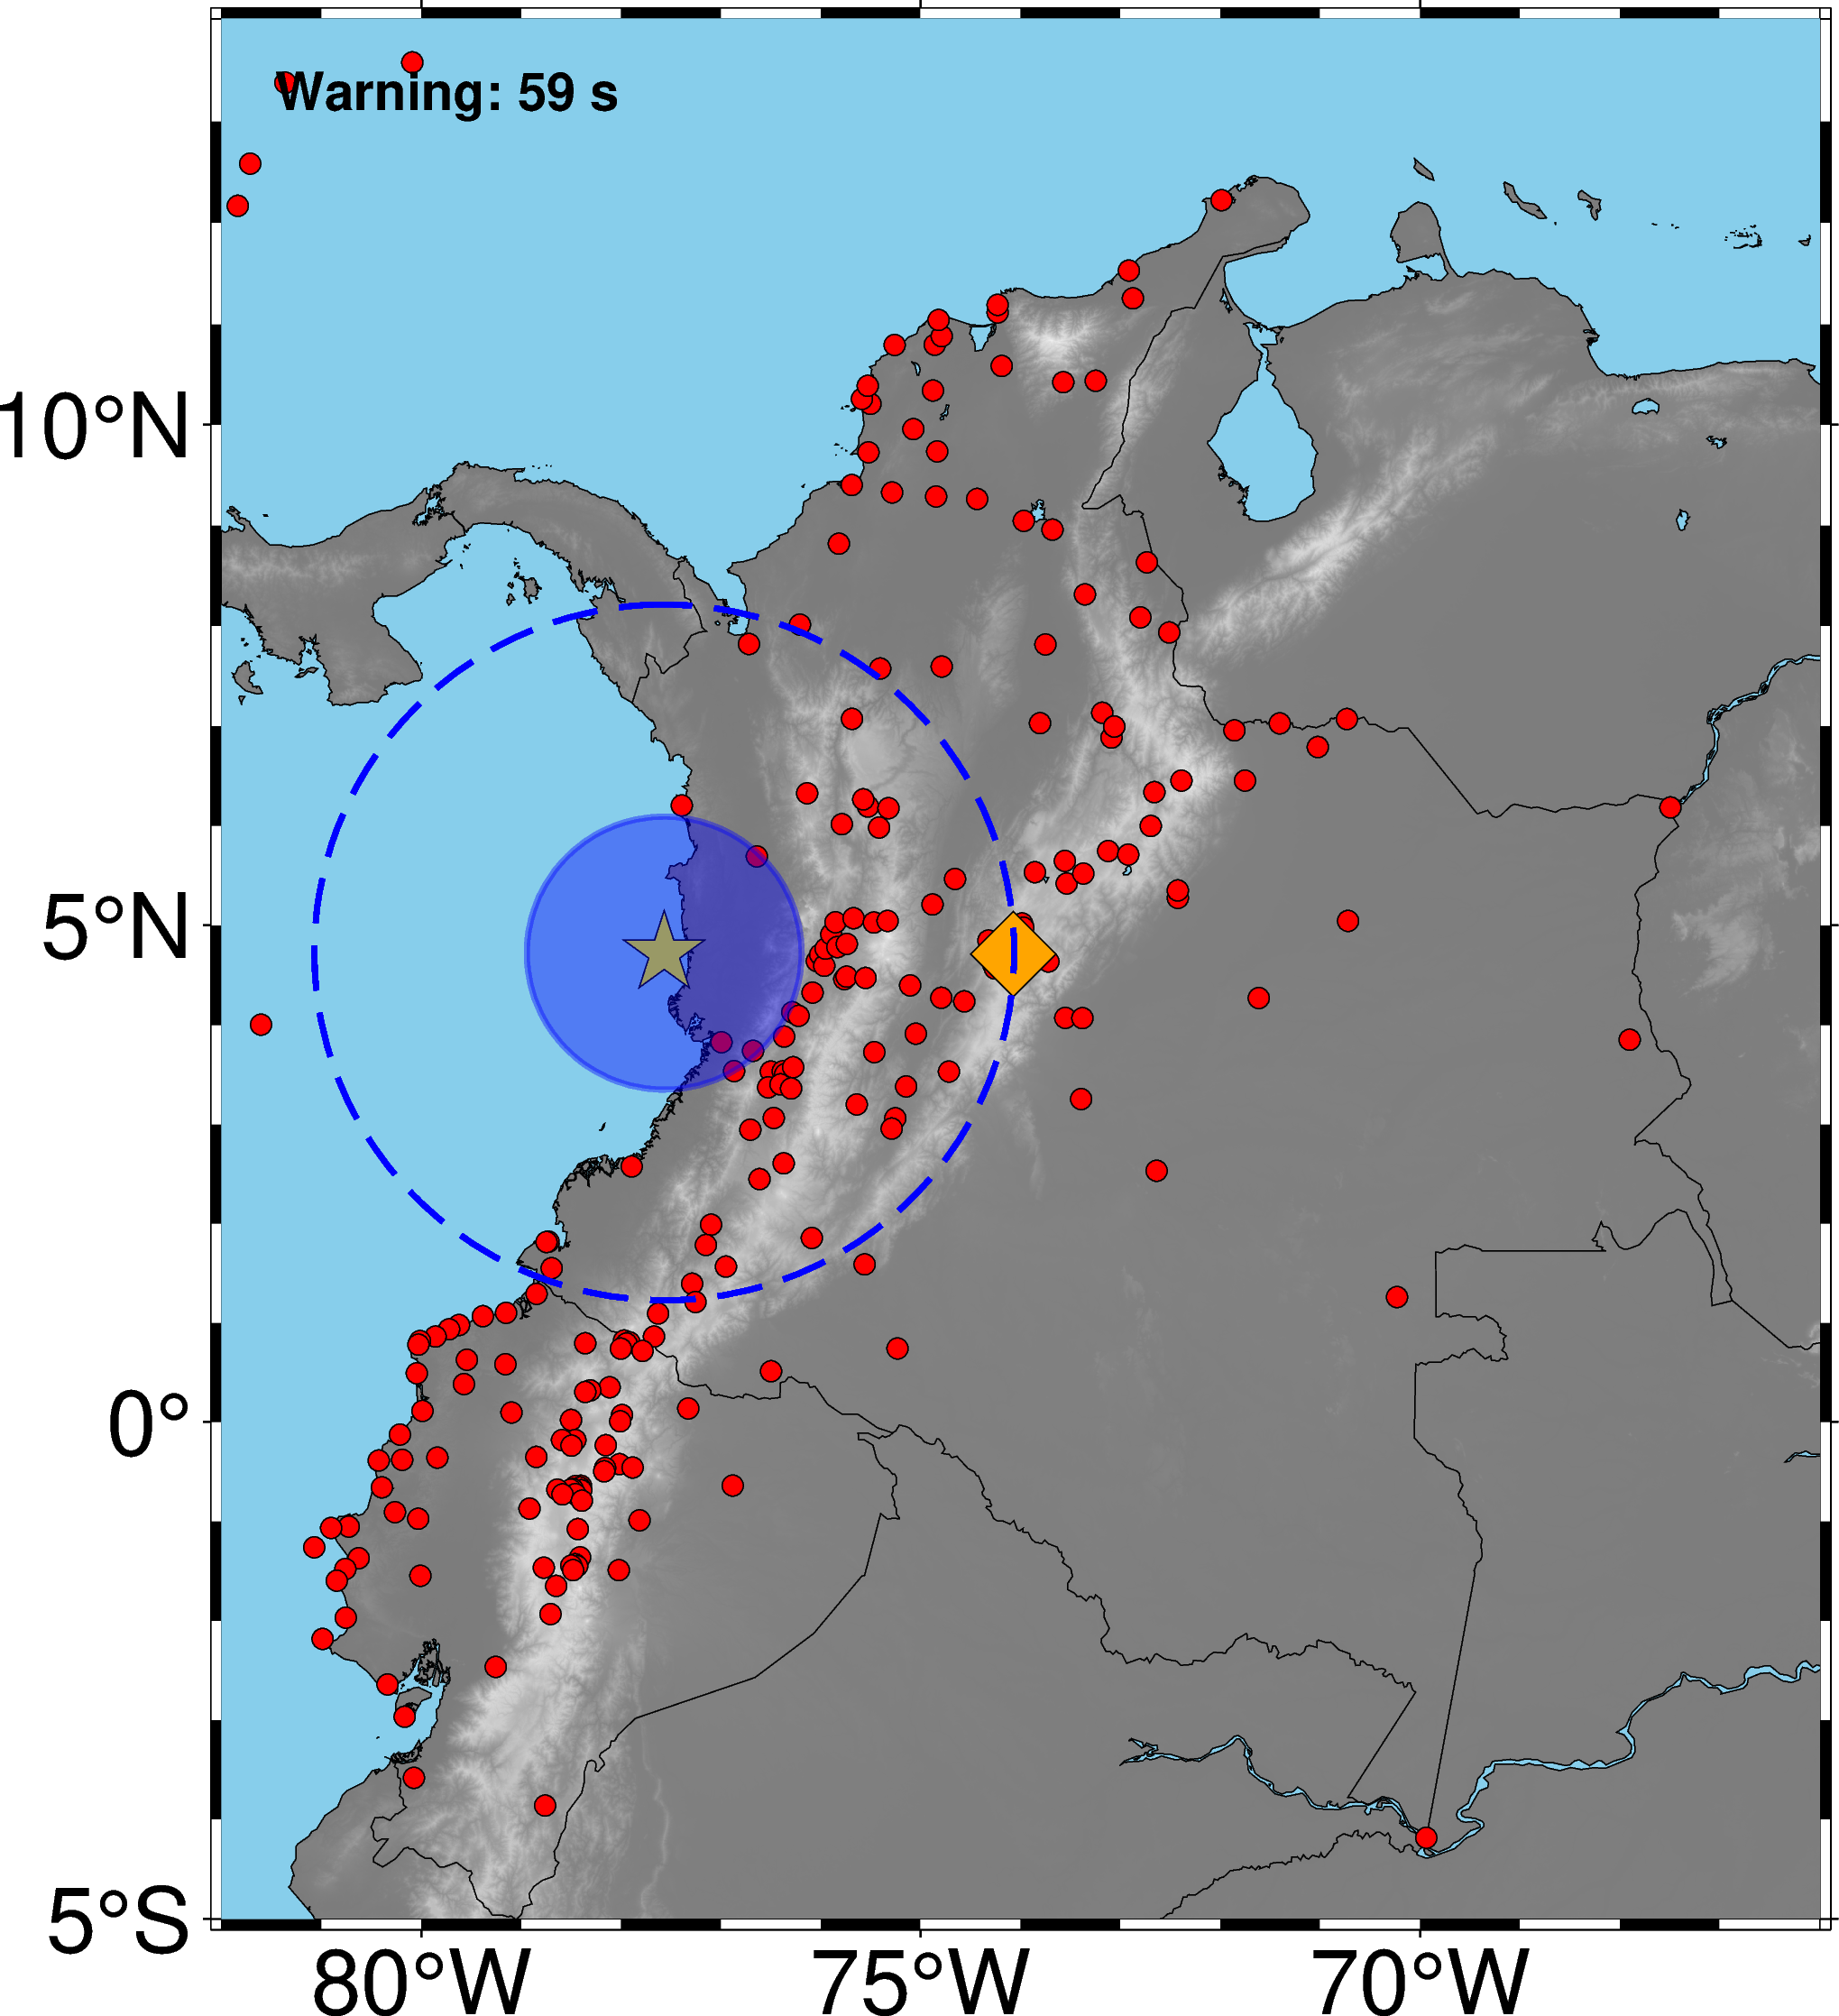

In [30]:
# Build figure using pyGMT
projection = "M-71.5/8/15c"
label= "Warning: " + "{:.0f}".format(warning_time_sec) + " s"
fig = pygmt.Figure()
with pygmt.config(FONT_ANNOT_PRIMARY="24p,Helvetica,black"):
    fig.basemap(projection=projection, region=[min_lon,max_lon,min_lat,max_lat], frame=True)
    fig.grdimage(grid=grid,cmap="gray")
    fig.coast(shorelines=True, water="skyblue", borders=1)
    #plot the sites
    fig.plot(x=df.lon, y=df.lat, style="c0.2c", color="red", pen="black")
    #plot the earthquake
    fig.plot(x=eq_loc[1], y=eq_loc[0], style="a.8c", color="yellow", pen="black")
    #plot the city
    fig.plot(x=city_loc[1], y=city_loc[0], style="d.8c", color="orange", pen="black")
    # plot the detection radius
    fig.plot(x=eq_loc[1], y=eq_loc[0], style="E0/"+"{:.1f}".format(dect_dist*2)+"/"+"{:.1f}".format(dect_dist*2), color="blue", transparency=60, pen="thicker,blue,solid")
    #plot radius when eq hits city
    fig.plot(x=eq_loc[1], y=eq_loc[0], style="E0/"+"{:.1f}".format(city_dist*2)+"/"+"{:.1f}".format(city_dist*2), pen="thicker,blue,dashed")
    fig.text(text=label, position="LT", offset=".5c/-.5c", font="14p,Helvetica-Bold,black")
    fig.show()

In [32]:
# If you want to save this in a different format
save_filename="warning"+".pdf"
fig.savefig(save_filename)